
This OCR uses the pre-trained EAST model (frozen_east_text_detection.pb) to detect text regions in a image. Then we look for the smallest bounding box that contains all the previously detected bounding boxes, we crop the image using that large boundong box and finally the pytesseract is used to recognize the text in the cropped image.

Before anything else download the frozen_east_text_detection.pb file from https://github.com/oyyd/frozen_east_text_detection.pb and set the variable PATH_TO_MODEL with the path to the frozen_east_text_detection.pb file.


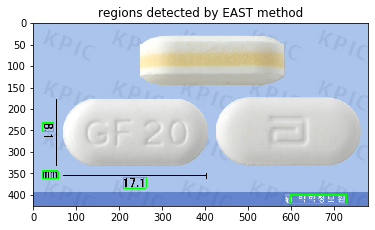

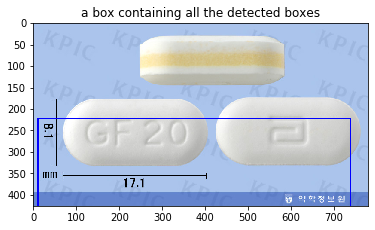

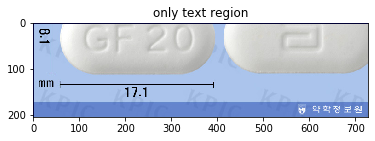

-----------recognized text------------
oc
wh
mm }————____,
17.1
Pee ee)

--------------------------------------


In [7]:
# Import required modules
import cv2 as cv
import matplotlib.pyplot as plt
import pytesseract
%matplotlib inline
import numpy as np
import copy
import math

PATH_TO_MODEL="C:/coding/python/opencv/EAST/frozen_east_text_detection.pb"

# decode prediction
def decode(scores, geometry, scoreThresh):
    
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if (score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = (
                [offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
            detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]


# get text bounding boxes
def get_EAST_regions(image):
    text_region_width = 1000
    confThreshold = 0.2
    nmsThreshold = 0.4
    inpWidth = 1600
    inpHeight = 1280
    model = PATH_TO_MODEL
    net = cv.dnn.readNet(model)
    outNames = []
    outNames.append("feature_fusion/Conv_7/Sigmoid")
    outNames.append("feature_fusion/concat_3")
    # outNames.append("feature_fusion/concat_3")#      
    #     width   It should be multiple by 32 height   It should be multiple by 32. thr | 0.5 nms         | 0.4
    image = image.astype(np.uint8)
    height_ = image.shape[0]
    width_ = image.shape[1]
    rW = width_ / float(inpWidth)
    rH = height_ / float(inpHeight)

    # Create a 4D blob from image.
    # blob = cv.dnn.blobFromImage(image, 1.0, (self.inpWidth, self.inpHeight), (123.68, 116.78, 103.94), True, False)
    blob = cv.dnn.blobFromImage(image, 1.0, (inpWidth, inpHeight))
    # Run the model
    net.setInput(blob)
    outs = net.forward(outNames)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())

    # Get scores and geometry
    scores = outs[0]
    geometry = outs[1]
    [boxes, confidences] = decode(scores, geometry, confThreshold)
    f_boxes = []
    # Apply NMS
    indices = cv.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        # get 4 corners of the rotated rect
        vertices = cv.boxPoints(boxes[i[0]])
        # scale the bounding box coordinates based on the respective ratios
        for j in range(4):
            vertices[j][0] *= rW
            vertices[j][1] *= rH
        f_boxes.append(vertices)

    return f_boxes


# draw_detected_bounding_boxes
def draw_detected_bounding_boxes(image, east_boxes):
    #     fig, ax = plt.subplots(figsize=(25, 20))
    points_x = []
    points_y = []
    for box in east_boxes:
        x, y, w, h = cv.boundingRect(box)
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(image)
    plt.title("regions detected by EAST method")
    plt.show()


# returns the bounding box containing all the previously detected bounding boxes 
def detect_text_region(image):
    east_boxes = get_EAST_regions(image)
    clone_img = copy.copy(image)
    draw_detected_bounding_boxes(clone_img, east_boxes)

    points_x = []
    points_y = []
    for box in east_boxes:
        x, y, w, h = cv.boundingRect(box)
        points_x.append(x)
        points_y.append(y)
        points_x.append(x + w)
        points_y.append(y + h)
    pad = 10
    x_min, y_min, x_max, y_max = min(points_x) - pad, min(points_y) - pad, max(points_x) + pad, max(points_y) + pad
    # show text region in a blue rectangle
    cv.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
    plt.imshow(image)
    plt.title("a box containing all the detected boxes")
    plt.show()

    return x_min, y_min, x_max, y_max


# recognize text using pytesseract
def recognize_image(image):
    lines = pytesseract.image_to_string(image, lang='eng+kor', config="--oem 1 --psm 6").split("\n")
    return lines


# main method
def run_ocr(image):
    image = cv.imread(file)
    if image is not None:
        image = image[:, :, ::-1]  # rbg to rgb ;)
        image = image.astype(np.uint8)
        h, w, d = image.shape

        # detect text region
        x_min, y_min, x_max, y_max = detect_text_region(image)

        # crop image to pass only text region to tesseract
        text_region = image[y_min:y_max, x_min:x_max]
        plt.imshow(text_region)
        plt.title("only text region")
        plt.show()

        # recognize image 
        lines = recognize_image(text_region)
        print("-----------recognized text------------")
        for line in lines:
            print(line)
        print("--------------------------------------")


if __name__ == "__main__":
    file = "./img/12.jpg"
    run_ocr(file)